In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import matplotlib.pyplot as plt
from tqdm import tqdm

In [198]:
# Generate the transformations that we will apply to the images
transform = tv.transforms.Compose([
    tv.transforms.ToTensor()
    # tv.transforms.RandomAffine(8, translate=(0.15, 0.15), scale=(0.9, 1.1), shear=0.1)
])

# Create a dataloader for the MNIST dateset
train_dataset = tv.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = tv.datasets.MNIST(root='./data', train=False, transform=tv.transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

torch.Size([28, 28])
tensor(0)


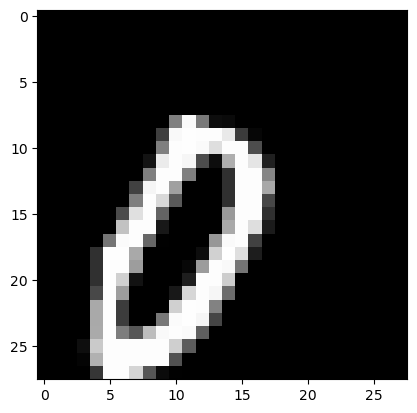

In [199]:
for X, T in train_loader:
    print(X[0, 0, :, :].shape)
    print(T[0])
    plt.imshow(X[0, 0, :, :].numpy(), cmap='gray')
    break

In [220]:
# Build a neural network model

class Conv_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3)
        self.fc = nn.Linear(in_features=16*5*5, out_features=10)

    def forward(self, X):
        X = self.conv1(X) # first convolutional layer
        # print(X.shape)
        X = F.relu(X) # activation function
        # print(X.shape)
        X = self.conv2(X) # second convolutional layer
        # print(X.shape)
        X = F.relu(X)
        # print(X.shape)
        X = F.max_pool2d(X, kernel_size=2, stride = 2)
        # print(X.shape)
        X = self.conv3(X)
        # print(X.shape)
        X = F.relu(X)
        # print(X.shape)
        X = F.max_pool2d(X, kernel_size=2, stride = 2) # max pooling layer
        # print(X.shape)
        X = X.reshape(-1, 16*5*5)
        # print(X.shape)
        X = self.fc(X)
        # print(X.shape)
        return X


In [221]:
# Create an instantiation of the model
model = Conv_Net()

In [222]:
# Create an optimiser
optimiser = optim.Adam(model.parameters(), lr=0.0005)

# Create a loss function
loss_function = nn.CrossEntropyLoss()

In [223]:
def train_one_epoch(model, optimiser, loss_function, train_loader):
    losses = []

    for X, T in tqdm(train_loader):
        optimiser.zero_grad()
        logits = model(X)
        loss = loss_function(logits, T)
        loss.backward()
        optimiser.step()

        losses.append(loss.item())
    
    return losses 

In [224]:
def plot_loss(losses):
    plt.plot(losses)
    plt.xlim(0, len(losses))
    plt.ylim(0, np.log(10))
    plt.xlabel('Optimiser step')
    plt.ylabel('Loss')

In [225]:
def find_test_accuracy(model, test_loader):
    correct = 0
    total = 0

    for X, T in tqdm(test_loader):
        logits = model(X)
        predictions = torch.argmax(logits, dim=1)
        correct += torch.sum(T == predictions).item()
        total += len(T)
    
    return correct / total

In [226]:
def train_epochs(model, optimiser, loss_function, train_loader, test_loader, n_epochs):
    losses = []
    accuracy = []

    for kk in range(n_epochs):
        losses = losses + train_one_epoch(model, optimiser, loss_function, train_loader)
        accuracy.append(find_test_accuracy(model, test_loader))
        print('Test accuracy: ', accuracy[-1])
    
    return losses, accuracy


100%|██████████| 1000/1000 [00:03<00:00, 268.09it/s]


Test accuracy:  0.95


100%|██████████| 1000/1000 [00:03<00:00, 266.83it/s]


Test accuracy:  0.9648


100%|██████████| 1000/1000 [00:04<00:00, 242.15it/s]


Test accuracy:  0.966


100%|██████████| 1000/1000 [00:03<00:00, 260.94it/s]


Test accuracy:  0.9739


100%|██████████| 1000/1000 [00:03<00:00, 254.11it/s]


Test accuracy:  0.9751


100%|██████████| 1000/1000 [00:03<00:00, 271.41it/s]


Test accuracy:  0.9796


100%|██████████| 1000/1000 [00:03<00:00, 252.48it/s]


Test accuracy:  0.9809


100%|██████████| 1000/1000 [00:03<00:00, 265.00it/s]


Test accuracy:  0.9799


100%|██████████| 1000/1000 [00:03<00:00, 269.96it/s]


Test accuracy:  0.984


100%|██████████| 1000/1000 [00:04<00:00, 243.06it/s]


Test accuracy:  0.9794


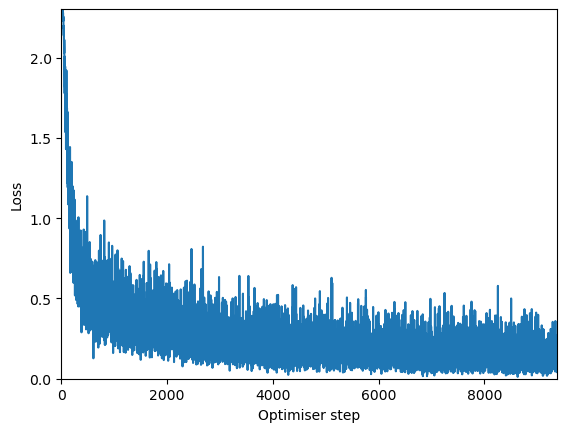

In [227]:
# Training for 10 epochs takes around 12 minutes on a CPU.
losses, accuracy = train_epochs(model, optimiser, loss_function, train_loader, test_loader, 10)

plot_loss(losses)

Text(0, 0.5, 'Loss')

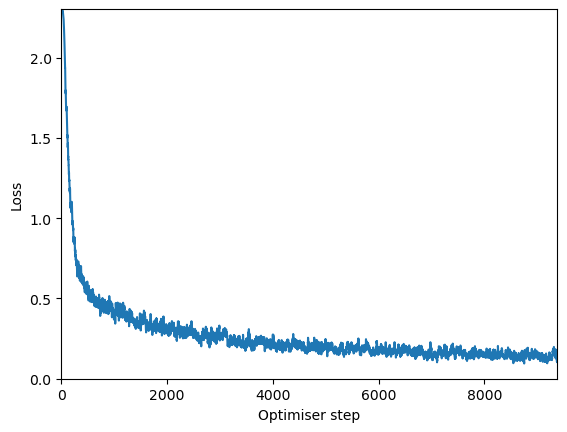

In [228]:
# Smooth the loss by applying a low pass filter
def smooth_loss(losses, alpha=0.9):
    smoothed_losses = [losses[0]]
    for kk in range(1, len(losses)):
        smoothed_losses.append(alpha * smoothed_losses[-1] + (1 - alpha) * losses[kk])
    
    return smoothed_losses

smoothed_losses = smooth_loss(losses)
plt.plot(smoothed_losses)
plt.xlim(0, len(losses))
plt.ylim(0, np.log(10))
plt.xlabel('Optimiser step')
plt.ylabel('Loss')
